# Exercise 1.15

Implement the experiment at pages 161 (section 4.5.2) of the book [An introduction to statistical learning](https://www.statlearning.com/).

> ## 4.5.2 <font color="blue">An Empirical Comparison</font>

> We now compare the empirical (practical) performance of logistic regression, LDA, QDA, naive Bayes, and KNN. We generated data from six different scenarios, each of which involves a binary (two-class) classification problem. In three of the scenarios, the Bayes decision boundary is linear, and in the remaining scenarios it is non-linear. For each scenario, we produced $100$ random training data sets. On each of these training sets, we fit each method to the data and computed the resulting test error rate on a large test set. Results for the linear scenarios are shown in <font color="green">Figure 4.11</font>, and the results for the non-linear scenarios are in <font color="green">Figure 4.12</font>. The KNN method requires selection of $K$, the number of neighbors (not to be confused with the number of classes in earlier sections of this chapter). We performed KNN with two values of $K$: $K = 1$, and a value of $K$ that was chosen automatically using an approach called cross-validation, which we discuss further in Chapter 5. We applied naive Bayes assuming univariate Gaussian densities for the features within each class (and, of course — since this is the key characteristic of naive Bayes — assuming independence of the features).\
In each of the six scenarios, there were $p = 2$ quantitative predictors.
The scenarios were as follows:

> <font color="blue">Scenario 1</font>: There were 20 training observations in each of two classes. The observations within each class were uncorrelated random normal variables with a different mean in each class. The left-hand panel of <font color="green">Figure 4.11</font> shows that LDA performed well in this setting, as one would expect since this is the model assumed by LDA. Logistic regression also performed quite well, since it assumes a linear decision boundary. KNN performed poorly because it paid a price in terms of variance that was not offset by a reduction in bias. QDA also performed worse than LDA, since it fit a more flexible classifier than necessary. The performance of naive Bayes was slightly better than QDA, because the naive Bayes assumption of independent predictors is correct.

> <font color="blue">Scenario 2</font>: Details are as in Scenario 1, except that within each class, the two predictors had a correlation of $-0.5$. The center panel of <font color="green">Figure 4.11</font> indicates that the performance of most methods is similar to the previous scenario. The notable exception is naive Bayes, which performs very poorly here, since the naive Bayes assumption of independent predictors is violated.

> <font color="blue">Scenario 3</font>: As in the previous scenario, there is substantial negative correlation between the predictors within each class. However, this time we generated $X_1$ and $X_2$ from the _t-distribution_, with 50 observations per class.The t-distribution has a similar shape to the normal distribution, but it has a tendency to yield more extreme points—that is, more points that are far from the mean. In this setting, the decision boundary was still linear, and so fit into the logistic regression framework. The set-up violated the assumptions of LDA, since the observations were not drawn from a normal distribution. The right-hand panel of <font color="green">Figure 4.11</font> shows that logistic regression outperformed LDA, though both methods were superior to the other approaches. In particular, the QDA results deteriorated considerably as a consequence of non-normality. Naive Bayes performed very poorly because the independence assumption is violated.

> <font color="blue">Scenario 4</font>: The data were generated from a normal distribution, with a correlation of $0.5$ between the predictors in the first class, and correlation of $-0.5$ between the predictors in the second class. This setup corresponded to the QDA assumption, and resulted in quadratic decision boundaries. The left-hand panel of <font color="green">Figure 4.12</font> shows that QDA outperformed all of the other approaches. The naive Bayes assumption of independent predictors is violated, so naive Bayes performs poorly.

> <font color="blue">Scenario 5</font>: The data were generated from a normal distribution with uncorrelated predictors. Then the responses were sampled from the logistic function applied to a complicated non-linear function of the predictors. The center panel of <font color="green">Figure 4.12</font> shows that both QDA and naive Bayes gave slightly better results than the linear methods, while the much more flexible KNN-CV method gave the best results. But KNN with $K = 1$ gave the worst results out of all methods. This highlights the fact that even when the data exhibits a complex non-linear relationship, a non-parametric method such as KNN can still give poor results if the level of smoothness is not chosen correctly.

> <font color="blue">Scenario 6</font>: The observations were generated from a normal distribution with a different diagonal covariance matrix for each class. However, the sample size was _very_ small: just $n = 6$ in each class. Naive Bayes performed very well, because its assumptions are met. LDA and logistic regression performed poorly because the true decision boundary is non-linear, due to the unequal covariance matrices. QDA performed a bit worse than naive Bayes, because given the very small sample size, the former incurred too much variance in estimating the correlation between the predictors within each class. KNN’s performance also suffered due to the very small sample size.

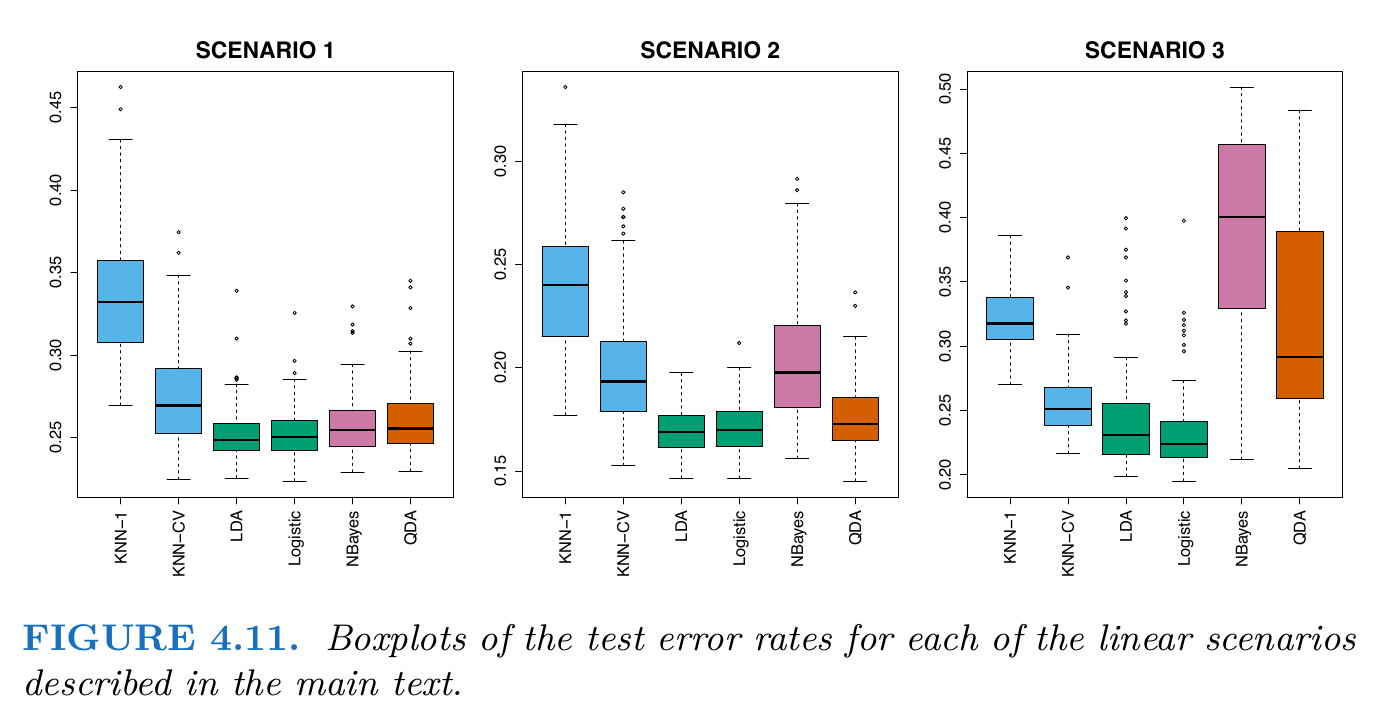

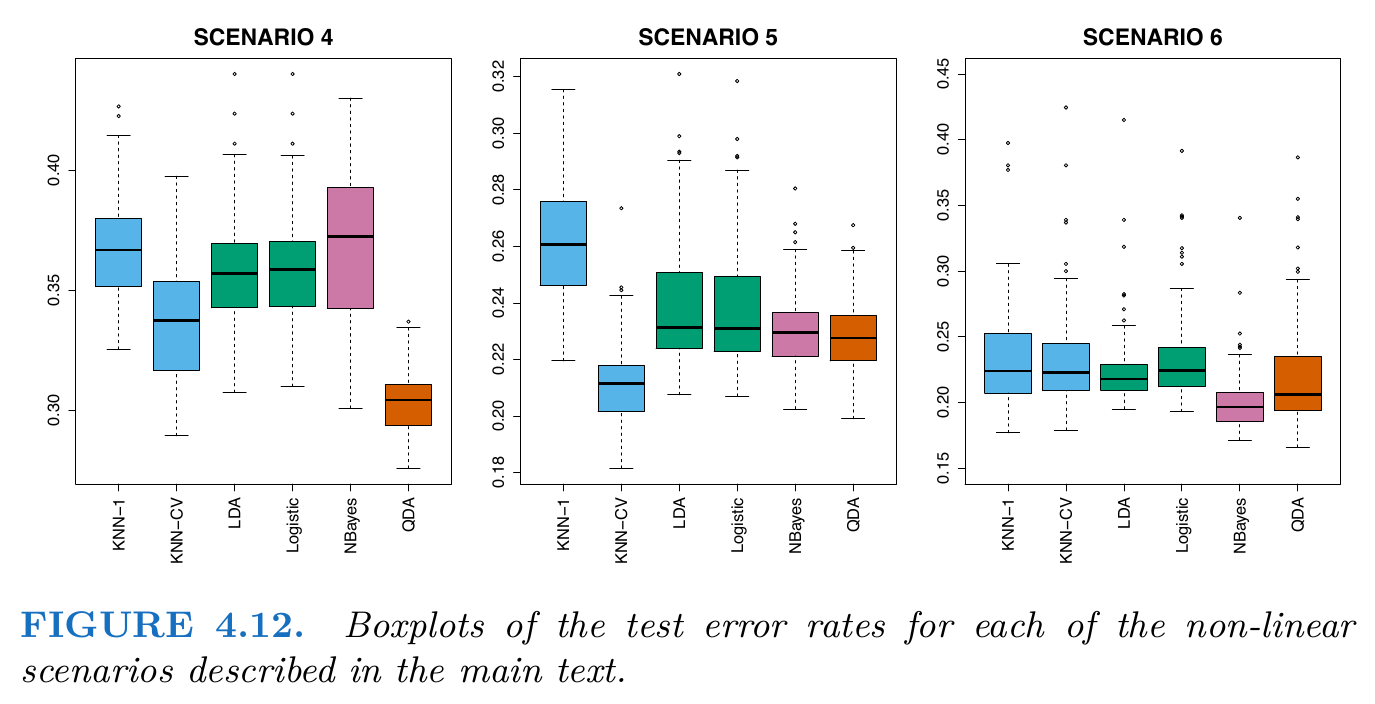

## Preamble

In [ ]:
import numpy as np                      # array and random
from scipy.stats import multivariate_t  # t-distribution

# models
from sklearn.linear_model          import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,\
                                          QuadraticDiscriminantAnalysis
from sklearn.naive_bayes           import GaussianNB
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.model_selection       import GridSearchCV, KFold

# graphics
from matplotlib.pyplot import subplots
from matplotlib.ticker import MultipleLocator


# fix random seed for reproducibility
rng = np.random.default_rng(2025)
cv_seed = int(rng.integers(0, 2**31))   # KFold wants an integer seed, not a generator
# cross validation parameters
cv = KFold(n_splits     = 5,
           shuffle      = True,
           random_state = cv_seed)

## Setup

In [ ]:
N_trains = 100    # number of training sets
n_test = 1000     # number of samples in the test set

Write function to generate data for each scenario.

In [ ]:
def generate_data(scenario, n=None):
  '''
    Generate a (X, y) draw for the given scenario.

    Parameters
    ----------
    scenario : int
       Which of the six data‐generating setups to use (1 through 6).
    n : int or couple or None, optional
       If None, use the scenario's default training sample size;
       if int, use half for each class;
       if couple, use the corresponding values for each class.

    Returns
    -------
    X : ndarray, shape (n0+n1, 2)
    y : ndarray, shape (n0+n1,)
  '''

  # default number of samples per class for each scenario
  defaults = {
      1: 20,
      2: 20,
      3: 50,
      4: 50,    # unspecified
      5: 50,    # unspecified
      6: 6
  }

  # if no override is given, use the default
  if n is None:
    n0 = n1 = defaults[scenario]
  elif np.array(n).shape == ():     # is int
    n0 = n1 = int(n / 2)
  elif np.array(n).shape == (2,):   # is couple
    n0, n1 = n
  else:
    raise TypeError("Invalid type for n")


  # draw (X_1, X_2) from the appropriate distribution for each scenario
  # `X0`, `X1` store `n0`,`n1` samples
  # their shape is (n_,2) since we have 2 features

  if   scenario == 1:
    # uncorrelated normals, different mean for each class
    mu0, mu1 = np.array([0,0]), np.array([1,1])
    Sigma = np.eye(2)
    X0 = rng.multivariate_normal(mean=mu0, cov=Sigma, size=n0)
    X1 = rng.multivariate_normal(mean=mu1, cov=Sigma, size=n1)

  elif scenario == 2:
    # same as 1, but -0.5 correlation within each class
    mu0, mu1 = np.array([0,0]), np.array([1,1])
    Sigma = np.array([[1, -0.5],
                      [-0.5, 1]])
    X0 = rng.multivariate_normal(mean=mu0, cov=Sigma, size=n0)
    X1 = rng.multivariate_normal(mean=mu1, cov=Sigma, size=n1)

  elif scenario == 3:
    # same as 2, but from t-distribution
    mu0, mu1 = np.array([0,0]), np.array([1,1])   # unspecified
    Sigma = np.array([[1, -0.5],
                      [-0.5, 1]])
    df = 2    # unspecified
    X0 = multivariate_t.rvs(loc=mu0, shape=Sigma, df=df, size=n0, random_state=rng)
    X1 = multivariate_t.rvs(loc=mu1, shape=Sigma, df=df, size=n1, random_state=rng)

  elif scenario == 4:
    # normals, class‐0 has corr +0.5, class‐1 has corr -0.5
    mu0, mu1 = np.array([0,0]), np.array([0.5,0.5])   # unspecified
    Sigma0 = np.array([[1, 0.5],
                       [0.5, 1]])
    Sigma1 = np.array([[1, -0.5],
                       [-0.5, 1]])
    X0 = rng.multivariate_normal(mean=mu0, cov=Sigma0, size=n0)
    X1 = rng.multivariate_normal(mean=mu1, cov=Sigma1, size=n1)

  elif scenario == 5:
    # uncorrelated normals, then labels via a non‐linear logistic model
    mu0, mu1 = np.array([0,0]), np.array([1,1])         # unspecified
    Sigma = np.eye(2)
    X0 = rng.multivariate_normal(mean=mu0, cov=Sigma, size=n0)
    X1 = rng.multivariate_normal(mean=mu1, cov=Sigma, size=n1)
    X = np.vstack([X0, X1])                             # stack temporarily to compute probabilities
    f = lambda x1, x2 : \
            x1**3 + np.log(x2**2)
    scores = f(X[:,0], X[:,1])                          # a complicated nonlinear score
    probs = 1 / (1 + np.exp(-scores))                   # logistic function
    y_all = rng.binomial(1, probs, size=probs.shape)    # sample y ~ Bernoulli(probs)
    X0 = X[y_all==0]                                    # split back for consistency
    X1 = X[y_all==1]

  elif scenario == 6:
    # different diagonal covariance per class
    mu0, mu1 = np.array([0,0]), np.array([1,1])   # unspecified
    Sigma0 = np.diag([1.0, 0.2])
    Sigma1 = np.diag([0.2, 1.0])
    X0 = rng.multivariate_normal(mean=mu0, cov=Sigma0, size=n0)
    X1 = rng.multivariate_normal(mean=mu1, cov=Sigma1, size=n1)

  else:
    raise ValueError("Scenario doesn't exist")


  # stack in one single matrix of shape (n0+n1, 2)
  X = np.vstack([X0, X1])

  # labels: 0 for first class, 1 for second
  y = np.concatenate([
      np.zeros(n0, dtype=int),
      np.ones (n1, dtype=int)
  ])

  return (X,y)

Write functions to initialize models and to train and test each model.

In [ ]:
def make_models():
  '''
  Return a dictionary mapping method names to unfitted sklearn estimator objects.
  '''

  return {
    'logistic': LogisticRegression(),
    'lda'     : LinearDiscriminantAnalysis(),
    'qda'     : QuadraticDiscriminantAnalysis(),
    'nbayes'  : GaussianNB(),
    'knn1'    : KNeighborsClassifier(n_neighbors=1),
    'knn_cv'  : GridSearchCV(
                  KNeighborsClassifier(),
                  param_grid  = {'n_neighbors':[1,3,5,7,9]},
                  cv          = cv,
                  n_jobs      = -1     # parallelize
                ),
  }


def train_test(model, X_train, Y_train, X_test, Y_test):
  '''
  Train and test the given classifier.
  Return the test error.
  '''

  model.fit(X_train, Y_train)         # fit on training set
  y_pred = model.predict(X_test)      # predict on test set
  return np.mean(y_pred != Y_test)    # compute 0–1 loss

## Execution

In [ ]:
scenarios = range(1,6+1)                  # [1,2,3,4,5,6]
errors = { sc: {} for sc in scenarios }   # empty dict for each scenario

models = make_models()    # initialize models


for scenario in scenarios:              # loop on scenarios
  errors[scenario] = { name: [] for name in models }      # empty dict for each model
  X_test,  Y_test  = generate_data(scenario, n=n_test)    # generate test set

  for name, model in models.items():    # loop on models

    for i in range(N_trains):           # loop on training sets
      X_train, Y_train = generate_data(scenario)                  # generate training set
      err = train_test(model, X_train, Y_train, X_test, Y_test)   # train, test and compute error
      errors[scenario][name].append(err)                          # add error to dictionary

## Plot

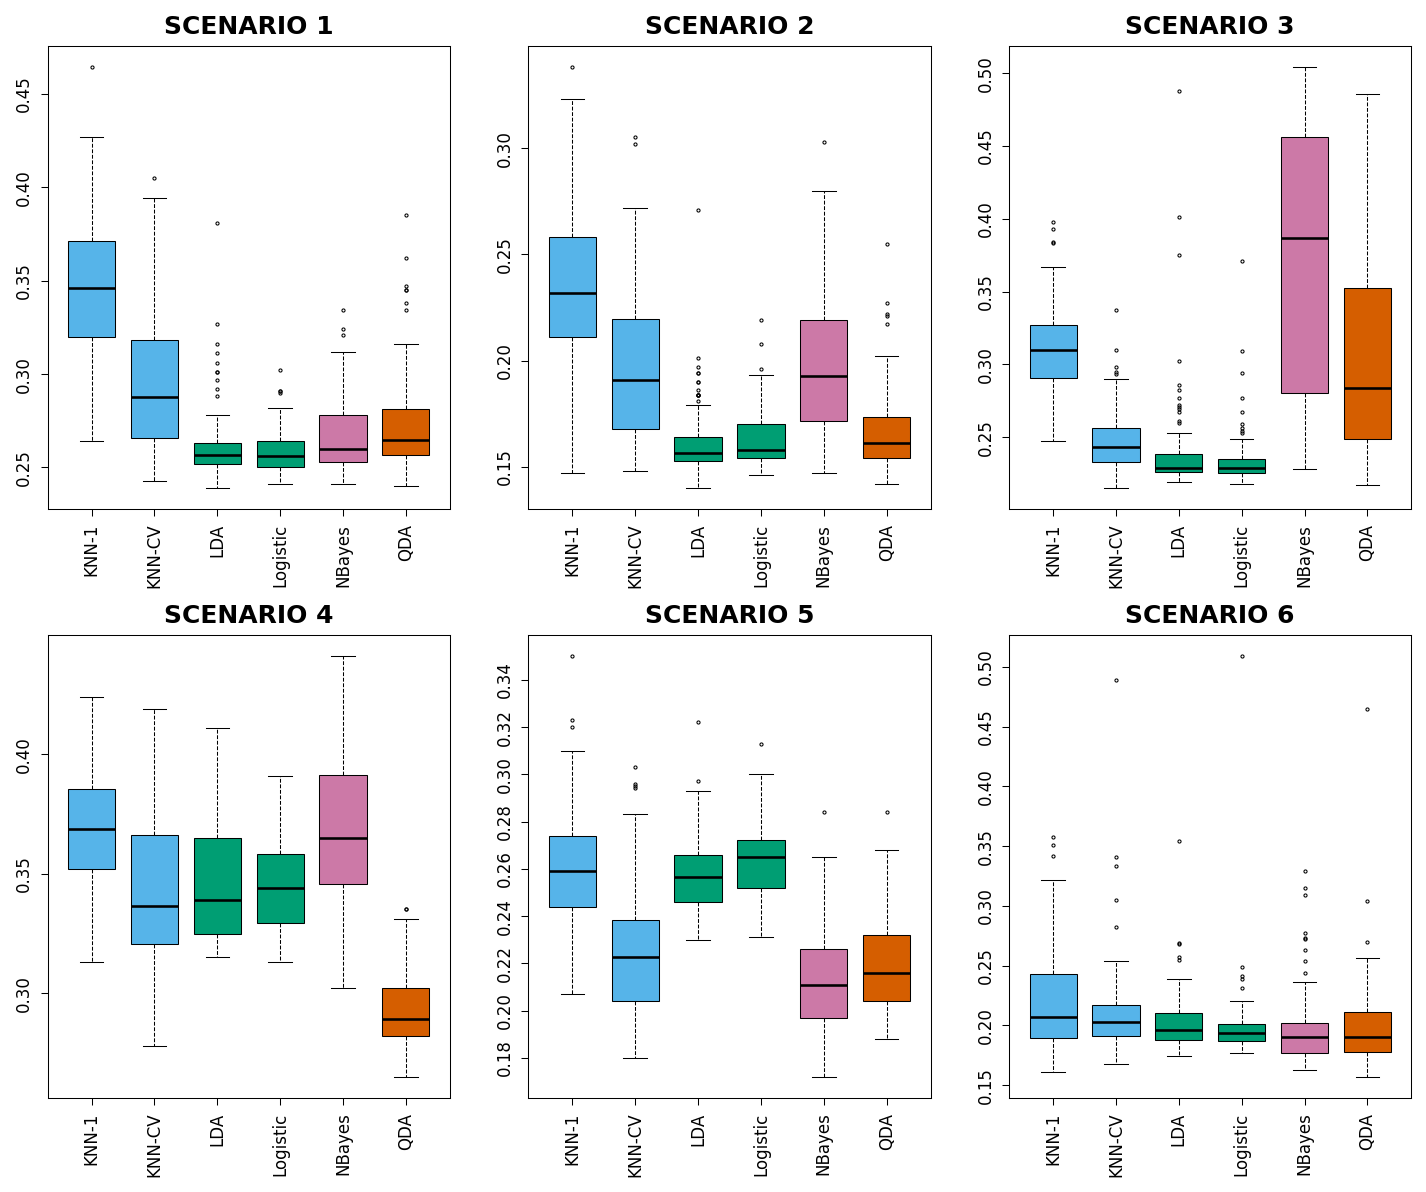

In [ ]:
fig, axes = subplots(nrows=2, ncols=3, figsize=(10.5, 8), dpi=150)
axes = axes.flatten()

plot_names = ['knn1',  'knn_cv', 'lda', 'logistic', 'nbayes', 'qda']
labels     = ['KNN‑1', 'KNN-CV', 'LDA', 'Logistic', 'NBayes', 'QDA']
colors     = ['#56b4e9','#56b4e9','#009e73','#009e73','#cc79a7','#d55e00']


for scenario in scenarios:
  ax = axes[scenario - 1]   # 0-based index
  data = [errors[scenario][name] for name in plot_names]    # list of lists

  bp = ax.boxplot(
      data,
      tick_labels   = labels,
      notch         = False,    # use boxes
      patch_artist  = True,     # to use colors
      widths        = 0.75,     # larger boxes
      #positions     = np.arange(len(data)) * 0.9,   # closer boxes
      boxprops      = dict(linewidth=0.50),
      medianprops   = dict(linewidth=1.25, color='black'),
      whiskerprops  = dict(linewidth=0.50, linestyle='--'),
      capprops      = dict(linewidth=0.50),
      flierprops    = dict(markersize=1.5, markeredgewidth=0.5),
  )

  # color the boxes
  for patch, col in zip(bp['boxes'], colors):
    patch.set_facecolor(col)


  ax.set_box_aspect(1.15)   # make y axis longer than x axis

  ax.set_title(f"SCENARIO {scenario}", fontweight='bold', fontsize=12)
  ax.tick_params(axis             = 'both',
                 width            = 0.5,              # smaller ticks
                 labelfontfamily  = 'sans-serif',
                 labelsize        = 8,                # smaller font
                 labelrotation    = 90,               # rotate labels
                )
  ax.yaxis.set_major_formatter("{x:.2f}")             # use two decimals for y values

  # use fixed step for y values
  if scenario == 5:
    ax.yaxis.set_major_locator(MultipleLocator(0.02))
  else:
    ax.yaxis.set_major_locator(MultipleLocator(0.05))

  # center rotated y labels
  for lbl in ax.get_yticklabels():
    lbl.set_va('center')

  # smaller spines
  for spine in ax.spines.values():
    spine.set_linewidth(0.5)

  # add padding from left/right spines
  pad = 0.7
  ax.set_xlim(1 - pad, len(data) + pad)

fig.tight_layout(rect=[0.07,0,1,1])

## Comparison

Compare with the originals:

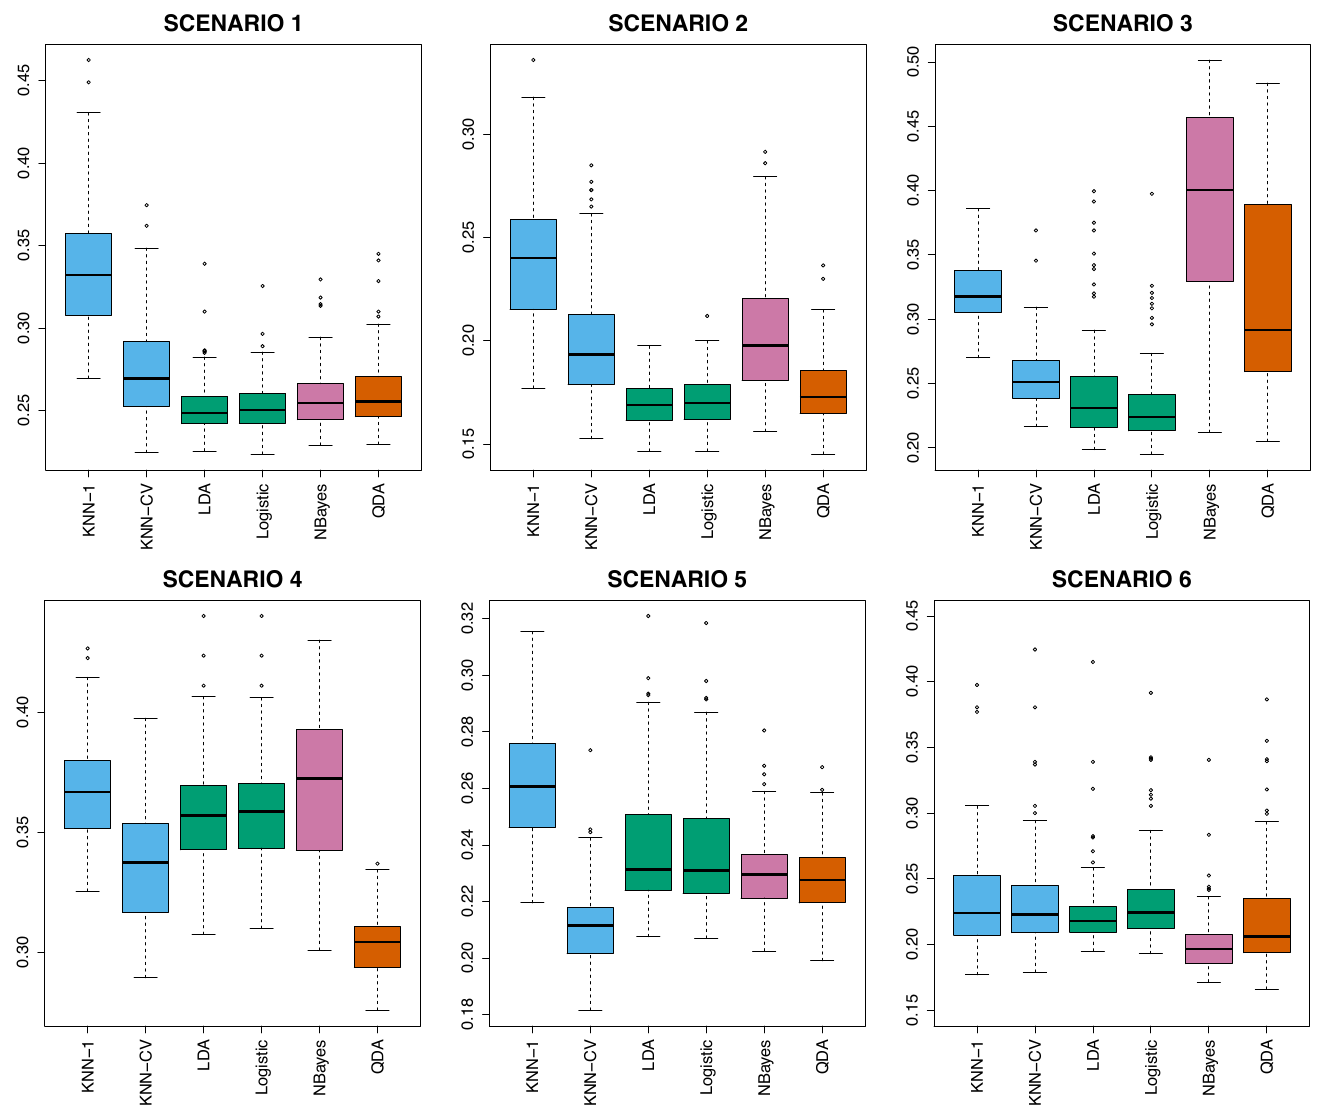

The qualitative behaviour is pretty similar. For the quantitative, I tried to adjust the unspecified parameters (in particular the values of the means) to get to the same scale of absolute errors.
We can see some discrepancy in the lenght of boxes/whiskers/flyers: this is likely due to the variance caused by the choice of train/test set, as we can see by changing the random seed.

One notable difference is in scenario 5, where the linear models perform worse while Naive Bayes and QDA perform better. \
Unfortunately, without knowing the exact non-linear function used, it's hard to replicate.

## Extra

Just for fun, we can study the distribution of scenario 5 by making some nice plots!

(100, 100)

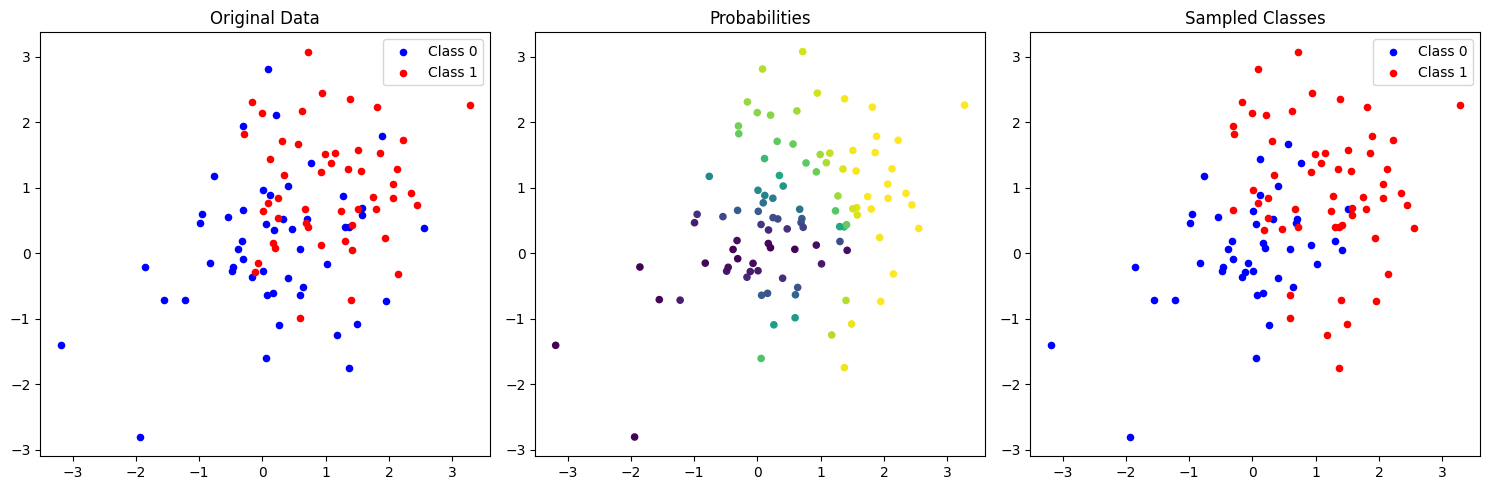

In [ ]:
n0 = n1 = 50
mu0, mu1 = np.array([0,0]), np.array([1,1])
Sigma = np.eye(2)
X0 = rng.multivariate_normal(mean=mu0, cov=Sigma, size=n0)
X1 = rng.multivariate_normal(mean=mu1, cov=Sigma, size=n1)
X = np.vstack([X0, X1])
f = lambda x1, x2 : \
        x1**3 + np.log(x2**2)
scores = f(X[:,0], X[:,1])
probs = 1 / (1 + np.exp(-scores))
y = rng.binomial(1, probs, size=probs.shape)

display((len(y==0),len(y==1)))


fig, (ax1, ax2, ax3) = subplots(nrows=1, ncols=3, figsize=(15,5))

ax1.scatter(X0[:,0], X0[:,1], c='blue', s=20, label='Class 0')
ax1.scatter(X1[:,0], X1[:,1], c='red',  s=20, label='Class 1')
ax1.legend()
ax1.set_title('Original Data')

scatter = ax2.scatter(X[:,0], X[:,1], c=probs, s=20, cmap='viridis')
#fig.colorbar(scatter, ax=ax2, label='Probability')
ax2.set_title('Probabilities')

ax3.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', s=20, label='Class 0')
ax3.scatter(X[y == 1, 0], X[y == 1, 1], c='red',  s=20, label='Class 1')
ax3.legend()
ax3.set_title('Sampled Classes')

fig.tight_layout();

_insert clever observation on how we can divine the correct non-linear function from these plots_